## Libs Imports

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from geopy.geocoders import Nominatim
import os, re, pycountry, folium, lxml.etree, urllib.request, math
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 500)
pd.set_option('display.max_rows', 500)
geolocator = Nominatim(user_agent="openclassroom_project_2")

## Utils

In [181]:
def feature_research(pattern:str, topic:str = None, percentage:bool=True) -> 'feature_list':
    feature_list = list()
    for row in EdStatsSeries.iterrows():
        if topic != None and percentage == True:
            if re.search('percentage', row[1]['Long definition'].lower()) \
            and re.search(pattern, row[1]['Long definition'].lower()) \
            and row[1]['Topic'] == topic:
                feature_list.append(row[0])
        elif topic != None and percentage == False:
            if re.search(pattern, row[1]['Long definition'].lower()) \
            and row[1]['Topic'] == topic:
                feature_list.append(row[0])
                
        elif topic == None and percentage == True:
            if re.search('percentage', row[1]['Long definition'].lower()) \
            and re.search(pattern, row[1]['Long definition'].lower()):
                feature_list.append(row[0])
            
        else: # topic == None and percentage == False
            if re.search(pattern, row[1]['Long definition'].lower()):
                feature_list.append(row[0])
    return feature_list

def get_territory_languages():
    url = "https://raw.githubusercontent.com/unicode-org/cldr/master/common/supplemental/supplementalData.xml"
    langxml = urllib.request.urlopen(url)
    langtree = lxml.etree.XML(langxml.read())

    territory_languages = {}
    for t in langtree.find('territoryInfo').findall('territory'):
        langs = {}
        for l in t.findall('languagePopulation'):
            langs[l.get('type')] = {
                'percent': float(l.get('populationPercent')),
                'official': bool(l.get('officialStatus'))
            }
        territory_languages[t.get('type')] = langs
    return territory_languages

def iso_code_alpha_3_to_alpha_2(x):
    try:
        return pycountry.countries.get(alpha_3=x).alpha_2
    except:
        return 1
    
def map_language(x):
    try:
        return language_dict[x]
    except:
        return np.NaN
    
def map_isolate_languages(x):
    if x in isolate_languages:
        return 'isolate_language'
    else:
        return x    

## Data imports

In [2]:
filepath = '/Users/leoguillaume/Documents/openclassrooms-projects/openclassrooms-project-2/data/Projet+Python_Dataset_Edstats_csv/'

In [3]:
csv_list = os.listdir(filepath)

In [4]:
for csv in csv_list:
    locals()[csv[:-4]] = pd.read_csv(os.path.join(filepath,csv))

In [5]:
for csv in csv_list:
    print(csv+'\n'+40*'-')
    locals()[csv[:-4]].info()
    print('\n')

EdStatsCountry.csv
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                  

## Data cleaning

**Restrict analysis on 1990 to 2015**

In [6]:
for column in EdStatsData:
    try:
        if int(column) > 2015 or int(column) < 1990:
            EdStatsData.drop(columns = column, inplace = True)
    except:
        pass

**Exclude low income country from analysis**

In [7]:
low_income_country_codes = EdStatsCountry[EdStatsCountry['Income Group'] == 'Low income']['Country Code'].values

In [8]:
EdStatsData = EdStatsData[~EdStatsData['Country Code'].isin(low_income_country_codes)]

**Others cleaning**

In [9]:
EdStatsData.drop(columns = 'Unnamed: 69', inplace = True)
EdStatsData.sort_index(axis = 1, inplace = True)
EdStatsData.reset_index(drop=True, inplace=True)

## Feature selection
### Ponctual feature

- education rate in upper secondary school
- education rate in tertiary school
- internet covering

**Metrics to feature selection**

- filling value rate

In [23]:
values_per_indicator_all_years = EdStatsData['Indicator Code'].value_counts()[0] * EdStatsData.iloc[:,:26].shape[1]
filling_rate = (EdStatsData.iloc[:,:26].notna().groupby(EdStatsData['Indicator Code'], sort = False).sum().sum(axis = 1) / values_per_indicator_all_years)

In [ ]:
EdStatsSeries.set_index('Series Code', inplace = True)

In [28]:
EdStatsSeries['filling_rate'] = filling_rate

- mean of years of most recents datapoints 

In [211]:
b = EdStatsData.loc[EdStatsData['Indicator Code'] == EdStatsData['Indicator Code'].unique()[0]].iloc[:,:26]

In [223]:
a.replace({'nan': np.NaN}, inplace = True)

In [229]:
a.transpose().ffill().iloc[-1,:]

0            NaN
3665         NaN
7330         NaN
10995        NaN
14660        NaN
18325        NaN
21990        NaN
25655        NaN
29320        NaN
32985        NaN
36650        NaN
40315        NaN
43980        NaN
47645        NaN
51310        NaN
54975        NaN
58640        NaN
62305        NaN
65970        NaN
69635        NaN
73300        NaN
76965        NaN
80630        NaN
84295        NaN
87960        NaN
91625     2014.0
95290     1997.0
98955        NaN
102620       NaN
106285    2010.0
109950    2014.0
113615    2013.0
117280    2009.0
120945    2011.0
124610    2013.0
128275       NaN
131940    2014.0
135605    2010.0
139270    2006.0
142935    2014.0
146600    2014.0
150265    2014.0
153930    2014.0
157595    2011.0
161260    2014.0
164925    2013.0
168590       NaN
172255    2013.0
175920    2013.0
179585    2014.0
183250    2014.0
186915    2014.0
190580    2014.0
194245    1994.0
197910       NaN
201575       NaN
205240    2014.0
208905       NaN
212570    2014

In [234]:
years = list()
index = list()
for indicator in tqdm(EdStatsData['Indicator Code'].unique()):
    df = EdStatsData.loc[EdStatsData['Indicator Code'] == indicator]
    columns = df['Country Name'].values
    df = df.iloc[:,:26]
    df.index = columns
    df = df.transform(lambda x: np.where(x.isnull(), x, x.name))
    df.replace({'nan': np.NaN}, inplace = True)
    try:
        #int(df.iloc[:, 1:].ffill(axis=1).iloc[:, -1].dropna().mean())
        int(df.transpose().ffill().iloc[-1,:].dropna().mean())
        years.append(int(df.iloc[:, 1:].ffill(axis=1).iloc[:, -1].dropna().mean()))
    except ValueError:
        years.append(0)
    index.append(indicator)    

100%|██████████| 3665/3665 [04:18<00:00, 14.16it/s]


In [235]:
mean_most_recent_years = pd.Series(years, index = index)
EdStatsSeries['mean_most_recent_years'] = mean_most_recent_years

**Search: education rate in upper secondary school**

In [236]:
upper_secondary_feature_list = feature_research('upper secondary', topic = 'Secondary', percentage = True)

EdStatsSeries.loc[EdStatsSeries.index.isin(upper_secondary_feature_list),
                  ['Long definition', 'mean_most_recent_years', 'filling_rate']
                 ].sort_values(['filling_rate', 'mean_most_recent_years'], ascending = [False, False]).head(5)

,Long definition,mean_most_recent_years,filling_rate
Series Code,,,
SE.SEC.ENRR.UP,"Total enrollment in upper secondary education, regardless of age, expressed as a percentage of the total population of official upper secondary education age.",2013.0,0.542714
SE.SEC.ENRR.UP.MA,"Total male enrollment in upper secondary education, regardless of age, expressed as a percentage of the male population of official upper secondary education age.",2013.0,0.529216
UIS.FEP.3,Number of female students at the upper secondary level expressed as a percentage of the total number of students (male and female) at the upper secondary level in a given school year.,2012.0,0.526072
UIS.FEP.3.GPV,Number of female general education students at the upper secondary level expressed as a percentage of the total number of general education students (male and female) at the upper secondary level in a given school year.,2013.0,0.491864
UIS.GTVP.3.GPV,"Total number of students enrolled in general programmes at the upper secondary education level, expressed as a percentage of the total number of students enrolled in all programmes (vocational and general) at the upper secondary level. General education is designed to develop learners’ general knowledge, skills and competencies and literacy and numeracy skills, often to prepare students for more advanced educational programmes at the same or higher ISCED levels and to lay the foundation for ...",2012.0,0.463018


> **SE.SEC.ENRR.UP**: Total enrollment in upper secondary education, regardless of age, expressed as a percentage of the total population of official upper secondary education age.

**Search: education rate in tertiary school**

In [164]:
tertiary_feature_list = feature_research('tertiary', topic = 'Tertiary', percentage = True)

EdStatsSeries.loc[EdStatsSeries.index.isin(tertiary_feature_list),
                  ['Long definition', 'mean_most_recent_years', 'filling_rate']
                 ].sort_values(['filling_rate', 'mean_most_recent_years',], ascending = [False, False]).head(5)

,Long definition,mean_most_recent_years,filling_rate
Series Code,,,
SE.TER.ENRR,"Total enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total population of the five-year age group following on from secondary school leaving.",2012.0,0.602996
SE.TER.ENRL.FE.ZS,Number of female students at the tertiary education level (ISCED 5 to 8) expressed as a percentage of the total number of students (male and female) at the tertiary education level (ISCED 5 to 8) in a given school year.,2013.0,0.570636
SE.TER.ENRR.FE,"Total female enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total female population of the five-year age group following on from secondary school leaving.",2012.0,0.555104
SE.TER.ENRR.MA,"Total male enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total male population of the five-year age group following on from secondary school leaving.",2012.0,0.555104
UIS.GOER.56,Total number of mobile tertiary students coming from a country/region as a percentage of the population of tertiary student age in their home country.,2012.0,0.514423


> **SE.TER.ENRR**: Total enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total population of the five-year age group following on from secondary school leaving.

**Search: internet covering**

In [166]:
EdStatsSeries.loc[EdStatsSeries.Topic == 'Infrastructure: Communications', 
                  ['Indicator Name', 'Long definition', 'filling_rate', 'mean_most_recent_years']
                 ]

,Indicator Name,Long definition,filling_rate,mean_most_recent_years
Series Code,,,,
IT.CMP.PCMP.P2,Personal computers (per 100 people),Personal computers are self-contained computers designed to be used by a single individual.,0.431398,2005.0
IT.NET.USER.P2,Internet users (per 100 people),"Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.",0.811945,2014.0


> **IT.NET.USER.P2**: Internet users are individuals who have used the Internet (from any location) in the last 3 months. The Internet can be used via a computer, mobile phone, personal digital assistant, games machine, digital TV etc.

### Temporal indicators

- upper secondary school growth
- tertiary school growth
- primary school growth
- education expenditure growth

**Metric to feature selection**

- filling rate

> **SE.SEC.ENRR.UP**: Total enrollment in upper secondary education, regardless of age, expressed as a percentage of the total population of official upper secondary education age.<br>
**SE.TER.ENRR**: Total enrollment in tertiary education (ISCED 5 to 8), regardless of age, expressed as a percentage of the total population of the five-year age group following on from secondary school leaving.

**Search: primary school**

In [172]:
primary_feature_list = feature_research('primary', topic = 'Primary', percentage = True)

EdStatsSeries.loc[EdStatsSeries.index.isin(primary_feature_list),
                  ['Long definition', 'mean_most_recent_years', 'filling_rate']
                 ].sort_values(['filling_rate', 'mean_most_recent_years',], ascending = [False, False]).head(5)

,Long definition,mean_most_recent_years,filling_rate
Series Code,,,
SE.PRM.ENRL.FE.ZS,Number of female students at the primary level expressed as a percentage of the total number of students (male and female) at the primary level in a given school year.,2014.0,0.763499
SE.PRM.ENRR,"Total enrollment in primary education, regardless of age, expressed as a percentage of the population of official primary education age. GER can exceed 100% due to the inclusion of over-aged and under-aged students because of early or late school entrance and grade repetition.",2014.0,0.751849
SE.PRM.ENRR.FE,"Total female enrollment in primary education, regardless of age, expressed as a percentage of the female population of official primary education age. GER can exceed 100% due to the inclusion of over-aged and under-aged students because of early or late school entrance and grade repetition.",2014.0,0.730769
SE.PRM.ENRR.MA,"Total male enrollment in primary education, regardless of age, expressed as a percentage of the male population of official primary education age. GER can exceed 100% due to the inclusion of over-aged and under-aged students because of early or late school entrance and grade repetition.",2014.0,0.730769
SE.PRM.PRIV.ZS,"Total number of students in primary education enrolled in institutions that are not operated by a public authority but controlled and managed, whether for profit or not, by a private body (e.g., non-governmental organisation, religious body, special interest group, foundation or business enterprise), expressed as a percentage of total number of students enrolled in primary education.",2013.0,0.643121


> **SE.PRM.ENRR**: Total enrollment in primary education, regardless of age, expressed as a percentage of the population of official primary education age. GER can exceed 100% due to the inclusion of over-aged and under-aged students because of early or late school entrance and grade repetition.

**Search: education expenditure**

In [175]:
expenditure_feature_list = feature_research('education', topic = 'Expenditures', percentage = True)

EdStatsSeries.loc[EdStatsSeries.index.isin(expenditure_feature_list),
                  ['Long definition', 'filling_rate']
                 ].sort_values(['filling_rate'], ascending = False).head(5)

,Long definition,filling_rate
Series Code,,
SE.XPD.TOTL.GD.ZS,"Total general (local, regional and central) government expenditure on education (current, capital, and transfers), expressed as a percentage of GDP. It includes expenditure funded by transfers from international sources to government. Divide total government expenditure for a given level of education (ex. primary, secondary, or all levels combined) by the GDP, and multiply by 100. A higher percentage of GDP spent on education shows a higher government priority for education, but also a highe...",0.391087
SE.XPD.TOTL.GB.ZS,"Total general (local, regional and central) government expenditure on education (current, capital, and transfers), expressed as a percentage of total general government expenditure on all sectors (including health, education, social services, etc.). It includes expenditure funded by transfers from international sources to government. Public education expenditure includes spending by local/municipal, regional and national governments (excluding household contributions) on educational institut...",0.347263
SE.XPD.TERT.ZS,"Expenditure on education by level of education, expressed as a percentage of total general government expenditure on education. Divide government expenditure on a given level of education (ex. primary, secondary) by total government expenditure on education (all levels combined), and multiply by 100. A high percentage of government expenditure on education spent on a given level denotes a high priority given to that level compared to others. When interpreting this indicator, one should take ...",0.320451
SE.XPD.PRIM.ZS,"Expenditure on education by level of education, expressed as a percentage of total general government expenditure on education. Divide government expenditure on a given level of education (ex. primary, secondary) by total government expenditure on education (all levels combined), and multiply by 100. A high percentage of government expenditure on education spent on a given level denotes a high priority given to that level compared to others. When interpreting this indicator, one should take ...",0.286243
SE.XPD.SECO.ZS,"Expenditure on education by level of education, expressed as a percentage of total general government expenditure on education. Divide government expenditure on a given level of education (ex. primary, secondary) by total government expenditure on education (all levels combined), and multiply by 100. A high percentage of government expenditure on education spent on a given level denotes a high priority given to that level compared to others. When interpreting this indicator, one should take ...",0.283839


> **SE.XPD.TOTL.GD.ZS**: Total general (local, regional and central) government expenditure on education (current, capital, and transfers), expressed as a percentage of GDP. It includes expenditure funded by transfers from international sources to government. 

## Feature analysis

In [180]:
ponctual_features = ['SE.SEC.ENRR.UP', 'SE.TER.ENRR', 'IT.NET.USER.P2']
temporal_features = ['SE.SEC.ENRR.UP', 'SE.TER.ENRR', 'SE.PRM.ENRR', 'SE.XPD.TOTL.GD.ZS']

### Cluster definition

- per regions
- per language
- per country

**Regions list**

In [177]:
EdStatsData = EdStatsData.merge(EdStatsCountry[['Region', 'Country Code', 'Income Group']], on ='Country Code')
regions_list = EdStatsData.Region.unique()

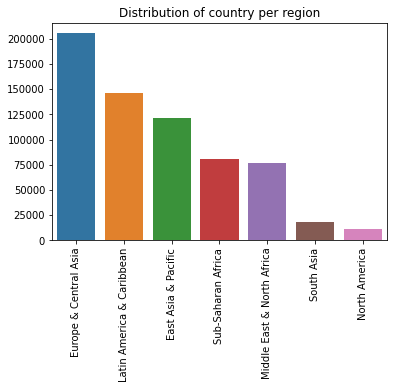

In [186]:
plt.title('Distribution of country per region')
sns.barplot(x = EdStatsData['Region'].value_counts().index, y = EdStatsData['Region'].value_counts().values)
plt.xticks(rotation = 90)
plt.show()

**Languages list**

In [182]:
EdStatsData['iso_code_alpha2'] = EdStatsData['Country Code'].apply(iso_code_alpha_3_to_alpha_2)
territory_languages = get_territory_languages()
language_dict = dict()
for name, iso_3, iso_2 in tuple(EdStatsCountry[['Short Name', 'Country Code', 'WB-2 code']].values): 
    try:
        language_dict[iso_3] =  list(territory_languages[iso_2].keys())[0]
    except:
        print(f'Error with {name}, code: {iso_2}')

Error with Arab World, code: 1A
Error with Channel Islands, code: JG
Error with Dem. Rep. Congo, code: ZR
Error with East Asia & Pacific (developing only), code: 4E
Error with East Asia & Pacific (all income levels), code: Z4
Error with Europe & Central Asia (developing only), code: 7E
Error with Europe & Central Asia (all income levels), code: Z7
Error with Euro area, code: XC
Error with European Union, code: EU
Error with High income, code: XD
Error with Heavily indebted poor countries (HIPC), code: XE
Error with Latin America & Caribbean (developing only), code: XJ
Error with Latin America & Caribbean (all income levels), code: ZJ
Error with Least developed countries: UN classification, code: XL
Error with Low income, code: XM
Error with Lower middle income, code: XN
Error with Low & middle income, code: XO
Error with Middle East & North Africa (all income levels), code: ZQ
Error with Middle income, code: XP
Error with Middle East & North Africa (developing only), code: XQ
Error wit

In [183]:
EdStatsData['language'] = EdStatsData['Country Code'].apply(map_language)
isolate_languages = EdStatsData.language.value_counts()[EdStatsData.language.value_counts() == 3665].index
EdStatsData['language_2'] = EdStatsData['language'].apply(map_isolate_languages)

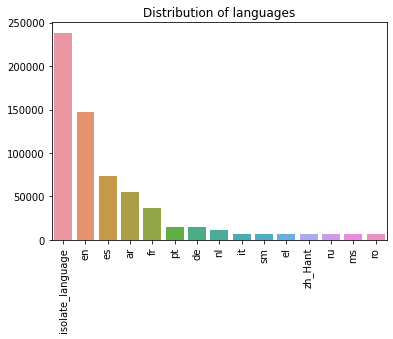

In [184]:
plt.title('Distribution of languages')
sns.barplot(x = EdStatsData['language_2'].value_counts().index, y = EdStatsData['language_2'].value_counts().values)
plt.xticks(rotation = 90)
plt.show()

### Ponctual features

In [257]:
last_values = EdStatsData.iloc[:,:26].ffill(axis = 1)['2015']
EdStatsData['last_value'] = last_values

In [278]:
round(df.set_index('Region').last_value.isna().sum(level=0) / df.set_index('Region').last_value.count(), 4)

Region
Europe & Central Asia         0.0151
Middle East & North Africa    0.0000
East Asia & Pacific           0.0000
Sub-Saharan Africa            0.0050
Latin America & Caribbean     0.0151
North America                 0.0000
South Asia                    0.0000
Name: last_value, dtype: float64

In [273]:
a = EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], ['Country Name', 'last_value', 'Region']]

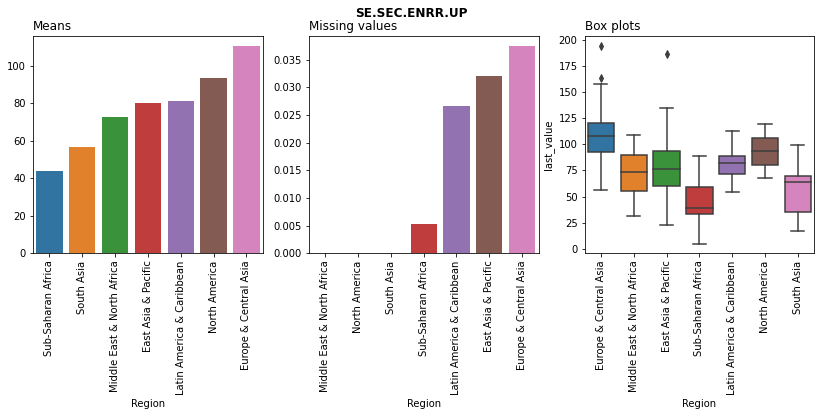

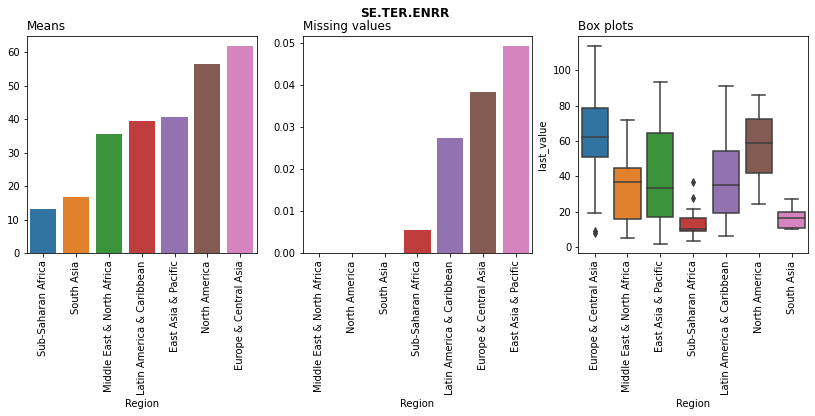

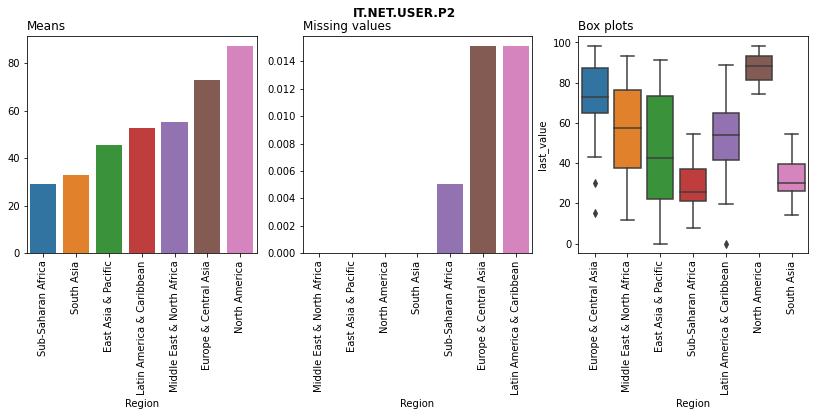

In [295]:
for feature in ponctual_features:
    
    plt.figure(figsize = (14, 4))
    plt.suptitle(t = f"{feature}", weight = 'bold')
    df = EdStatsData.loc[EdStatsData['Indicator Code'] == feature, ['Country Name', 'last_value', 'Region']]
    
    plt.subplot(1, 3, 1)
    plt.title(label= 'Means', loc = 'left')
    df_mean = df.groupby('Region').last_value.mean().sort_values()
    sns.barplot(x = df_mean.index, y = df_mean.values)
    plt.xticks(rotation = 90)
    
    plt.subplot(1, 3, 2)
    plt.title(label= 'Missing values', loc = 'left')
    df_missing = (df.set_index('Region').last_value.isna().sum(level=0) / df.set_index('Region').last_value.count()).sort_values()
    sns.barplot(x = df_missing.index, y = df_missing.values)
    plt.xticks(rotation = 90)
    
    plt.subplot(1, 3, 3)
    plt.title(label= 'Box plots', loc = 'left')
    sns.boxplot(x='Region', y= 'last_value', data=df)
    plt.xticks(rotation = 90)
    plt.show()

In [307]:
from plotly.express import scatter

In [ ]:
EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 

In [321]:
dict(EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0]].set_index('Country Name').Region)

{'Arab World': nan,
 'East Asia & Pacific': nan,
 'East Asia & Pacific (excluding high income)': nan,
 'Euro area': nan,
 'Europe & Central Asia': nan,
 'Europe & Central Asia (excluding high income)': nan,
 'European Union': nan,
 'Heavily indebted poor countries (HIPC)': nan,
 'High income': nan,
 'Latin America & Caribbean': nan,
 'Latin America & Caribbean (excluding high income)': nan,
 'Least developed countries: UN classification': nan,
 'Low & middle income': nan,
 'Low income': nan,
 'Lower middle income': nan,
 'Middle East & North Africa': nan,
 'Middle East & North Africa (excluding high income)': nan,
 'Middle income': nan,
 'North America': nan,
 'OECD members': nan,
 'South Asia': nan,
 'Sub-Saharan Africa': nan,
 'Sub-Saharan Africa (excluding high income)': nan,
 'Upper middle income': nan,
 'World': nan,
 'Albania': 'Europe & Central Asia',
 'Algeria': 'Middle East & North Africa',
 'American Samoa': 'East Asia & Pacific',
 'Andorra': 'Europe & Central Asia',
 'Angola

In [ ]:
EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value']

In [ ]:
sns.scatterplot(data=tips, x="total_bill", y="tip", hue=)

In [ ]:
color_map <- c(Pass="yellow", High="red", Low= "cyan",
                 Sigma= "magenta", Mean='limegreen', Fail="blue", Median="violet")

In [334]:
EdStatsData.Region.value_counts(dropna = False)

Europe & Central Asia         205240
Latin America & Caribbean     146600
East Asia & Pacific           120945
NaN                            98955
Sub-Saharan Africa             80630
Middle East & North Africa     76965
South Asia                     18325
North America                  10995
Name: Region, dtype: int64

In [ ]:
color_map <- c(Pass="yellow", High="red", Low= "cyan",
                 Sigma= "magenta", Mean='limegreen', Fail="blue", Median="violet")

In [344]:
(EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value'].values,
                  EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'last_value'].values,
                  EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'Region'].values).

(array([ 55.59698105,  79.54934692,  77.17327881, 113.22857666,
        108.24778748,  95.9682312 , 117.24172211,  28.98097038,
        107.80890656,  80.04322052,  79.43833923,  32.53773117,
         60.04206085,  27.81620979,  56.78779984,  66.64186096,
         62.56567001,  67.23043823,  95.64087677, 100.98201752,
         52.37538147,  35.09997177,  35.09872818,  86.7950592 ,
         67.64936829,  89.46027374,  62.72114182,          nan,
                 nan,  21.09861946,  82.02459717,  85.23262024,
         89.92696381, 106.32550049, 186.42788696,  99.61969757,
         58.00434113,  87.46269989, 102.81664276, 112.88591003,
        119.31694031, 158.07752991,  59.8052597 ,  67.57093811,
         69.16970062,  81.23213196,  56.67049026,  55.94638824,
         91.42032623,  92.70401764, 107.80135345,  72.63793182,
         43.40916061, 119.05309296,          nan,          nan,
         99.61875916,  89.65190125,  82.33493042,  38.28018951,
        108.981987  ,  27.75703049,  92.

In [343]:
for x, y, reg in (EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value'].values,
                  EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'last_value'].values,
                  EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'Region'].values):
    print(x, y,reg)

ValueError: too many values to unpack (expected 3)

ValueError: too many values to unpack (expected 3)

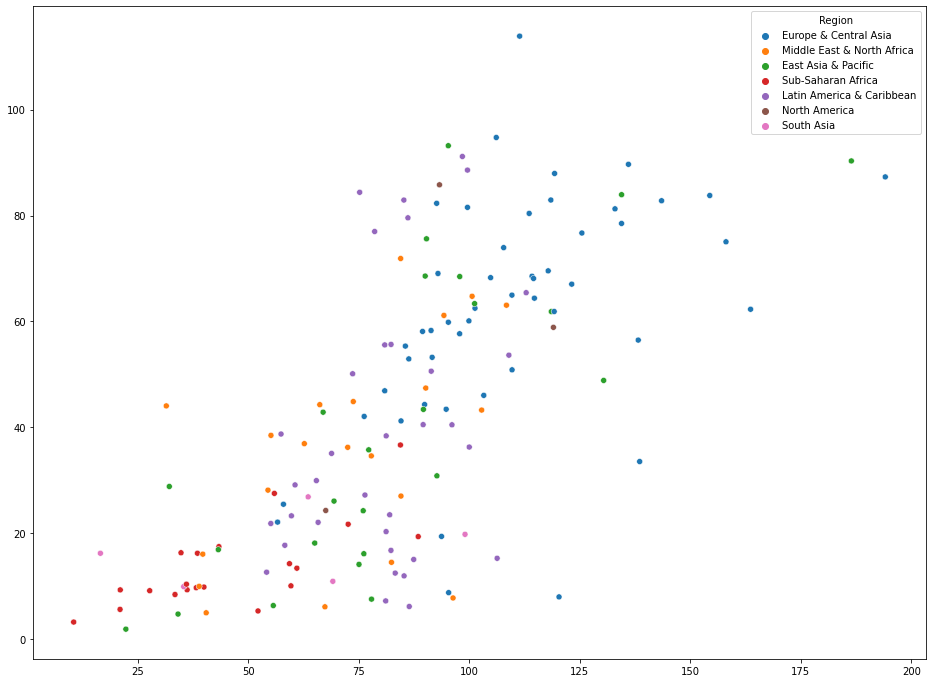

In [342]:
plt.figure(figsize = (16, 12))
sns.scatterplot(x=EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value'].values,
        y=EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'last_value'].values,
        hue=EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'Region'])
for x, y, reg in (EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value'].values,
                  EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'last_value'].values,
                  EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'Region'].values):
    plt.text(x = x, y = y, s = reg)

<AxesSubplot:>

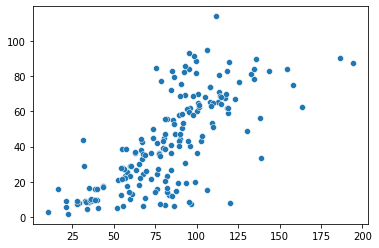

In [305]:
sns.scatterplot(x=EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value'].values,
                y=EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[1], 'last_value'].values)


In [301]:
EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0], 'last_value']

1343       55.596981
5008       79.549347
8673       77.173279
12338     113.228577
16003     108.247787
19668      95.968231
23333     117.241722
26998      28.980970
30663     107.808907
34328      80.043221
37993      79.438339
41658      32.537731
45323      60.042061
48988      27.816210
52653      56.787800
56318      66.641861
59983      62.565670
63648      67.230438
67313      95.640877
70978     100.982018
74643      52.375381
78308      35.099972
81973      35.098728
85638      86.795059
89303      67.649368
92968      89.460274
96633      62.721142
100298           NaN
103963           NaN
107628     21.098619
111293     82.024597
114958     85.232620
118623     89.926964
122288    106.325500
125953    186.427887
129618     99.619698
133283     58.004341
136948     87.462700
140613    102.816643
144278    112.885910
147943    119.316940
151608    158.077530
155273     59.805260
158938     67.570938
162603     69.169701
166268     81.232132
169933     56.670490
173598     55

In [ ]:
def plot_ponctual(feature:str, year:int, groupby:str):
    
    plt.figure(figsize = (14, 4))
    plt.suptitle(t = f"{feature}")
    df = EdStatsData.loc[EdStatsData['Indicator Code'] ==feature, ['Country Name', str(year), groupby]]
    
    plt.subplot(1, 3, 1)
    plt.title(label= 'Missing values distribution')
    missing_values = df.groupby(groupby).count()[str(year)] / df.groupby(groupby).count()['Country Name'] 
    sns.barplot(x = missing_values.index, y = missing_values.values)
    plt.xticks(rotation = 90)
    
    plt.subplot(1, 3, 2)
    plt.title(label= 'Mean distribution')
    df2 = df.groupby(groupby).mean()
    sns.barplot(y= df2[str(year)], x= df2.index)
    plt.xticks(rotation = 90)
    
    plt.subplot(1, 3, 3, label= 'Box plots')
    sns.boxplot(x=groupby, y= str(year), data=df)
    plt.xticks(rotation = 90)
    plt.show()

In [245]:
dd

In [254]:
EdStatsData.last_value

0                   NaN
1                   NaN
2                   NaN
3                   NaN
4             85.320152
              ...      
758650    125225.000000
758651        88.714560
758652        86.509450
758653         0.948610
758654        91.195630
Name: last_value, Length: 758655, dtype: float64

In [271]:
EdStatsData.set_index('Region').isna().sum(level=0)

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,Country Code,Country Name,Indicator Code,Indicator Name,Income Group,iso_code_alpha2,language,language_2,last_value
Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Europe & Central Asia,175194,188501,188475,187204,186413,170570,186173,187209,184621,174261,159101,172839,172698,168584,171430,156021,165555,167485,168924,164528,139693,163965,162775,168816,174545,167521,0,0,0,0,0,0,10995,10995,113247
Middle East & North Africa,62394,68404,67860,68075,67884,61734,68041,68142,68826,63642,57917,64156,63746,62622,62983,57121,62984,62148,63628,63243,52353,61459,62876,62683,65501,62759,0,0,0,0,0,0,7330,7330,39934
East Asia & Pacific,105378,112355,112044,112097,112094,104675,112313,112462,109817,106595,99778,106316,106281,104958,106029,99630,104794,105301,105736,104510,92704,104899,104692,105301,107514,103862,0,0,0,0,0,0,3665,3665,77933
Sub-Saharan Africa,67281,72564,72587,73374,72410,67819,73014,73791,71443,69238,63296,68680,68632,68532,68752,62297,68275,68167,68007,68033,58200,67558,66767,67843,70131,67733,0,0,0,0,0,0,3665,3665,43068
Latin America & Caribbean,127040,134736,134850,134423,135454,126358,134827,135551,134228,127283,116714,125906,125059,126399,123995,114946,122710,122267,122818,121421,104408,123697,123141,123379,128302,125156,0,0,0,0,0,0,0,0,87403
North America,9449,10150,10281,10127,10092,9182,10116,10394,9885,9664,8741,9513,9494,9337,9489,8633,9429,9710,9760,9501,8070,9193,9005,9520,9724,9287,0,0,0,0,0,0,0,0,6499
South Asia,15151,16736,16659,16692,16709,15269,16869,16813,16345,16013,14442,15638,15982,15942,16096,13901,14891,15549,15077,15169,12043,14850,14635,14560,15779,15505,0,0,0,0,0,0,0,0,9400


In [270]:
EdStatsData.groupby('Region').last_value.isna()

AttributeError: 'SeriesGroupBy' object has no attribute 'isna'

In [191]:
a = EdStatsData.loc[EdStatsData['Indicator Code'] == ponctual_features[0]].iloc[:,:26]

In [201]:
z = list(a.iterrows())[0][1]

In [208]:
z.ffill().iloc[-1]

55.596981048584006

In [196]:
for row in a.iterrows():
    print(row[1])

1990          NaN
1991          NaN
1992          NaN
1993          NaN
1994    42.139591
1995    42.167831
1996    41.035789
1997    42.371090
1998    43.380428
1999    43.782581
2000    44.765308
2001    46.647480
2002    47.064449
2003    50.003590
2004    51.903252
2005    51.302929
2006    50.565079
2007    48.546928
2008    47.940521
2009    47.260841
2010    49.385880
2011    53.924438
2012    55.756699
2013    55.670872
2014    55.596981
2015          NaN
Name: 1343, dtype: float64
1990          NaN
1991          NaN
1992          NaN
1993          NaN
1994    32.676449
1995    35.292820
1996    37.904530
1997    39.941231
1998    42.885990
1999    45.133049
2000    45.035278
2001    43.574081
2002    43.069870
2003    44.004051
2004    45.813389
2005    47.596748
2006    51.050549
2007    56.336529
2008    60.555321
2009    64.532669
2010    67.705742
2011    71.167213
2012    74.200012
2013    79.657349
2014    79.549347
2015          NaN
Name: 5008, dtype: float64
1990      

Name: 606068, dtype: float64
1990   NaN
1991   NaN
1992   NaN
1993   NaN
1994   NaN
1995   NaN
1996   NaN
1997   NaN
1998   NaN
1999   NaN
2000   NaN
2001   NaN
2002   NaN
2003   NaN
2004   NaN
2005   NaN
2006   NaN
2007   NaN
2008   NaN
2009   NaN
2010   NaN
2011   NaN
2012   NaN
2013   NaN
2014   NaN
2015   NaN
Name: 609733, dtype: float64
1990   NaN
1991   NaN
1992   NaN
1993   NaN
1994   NaN
1995   NaN
1996   NaN
1997   NaN
1998   NaN
1999   NaN
2000   NaN
2001   NaN
2002   NaN
2003   NaN
2004   NaN
2005   NaN
2006   NaN
2007   NaN
2008   NaN
2009   NaN
2010   NaN
2011   NaN
2012   NaN
2013   NaN
2014   NaN
2015   NaN
Name: 613398, dtype: float64
1990          NaN
1991          NaN
1992          NaN
1993          NaN
1994          NaN
1995          NaN
1996    85.741081
1997    86.309517
1998    85.638191
1999    82.031227
2000    72.610580
2001    74.365646
2002    78.464470
2003    83.663963
2004    89.192711
2005    90.789543
2006    90.377068
2007    90.945702
2008    90.235382